# NSynth Encoding Manipulation Experiments

## Max Keene

**This notebook is setup to be run in colab.**

In this notebook you can encode and decode your own audio files with NSynth. You can also try out a number of new methods for manipulating encodings. 

The goal of the experiments is to explore new musical possibilities with nsynth. The main focus around these experiments is on the modulation of an encoding in the lantent space that nsynth creates. When a sound is fed into the nsynth encdoer it is essentially given a point in that latent space, and by moving the point slightly the sound is changed slightly. The latent space of nsynth has 16 dimentions, which means there are 16 axes of control to potentially modulate. The axial position of an encoding is stored in what are called channels of the encoding. This is where it really gets musically interesting. The only known sonic effect of an individual channel is that the further its value is from zero the greater effect it has on what the decoder generates. Because of this it is very hard to exactly predict what sound the experiment will create, but it will be somewhat related to the originally encoded audio. My recommendation is to generate a lot of different manipulated encodings and decode them all at once, because you'll get some you like and some you don't.

In [0]:
#@title Setup Environment
#@test {"output": "ignore"}

# %%capture 


print("Installing packages...")
!pip install -q -U magenta
!apt-get update
!apt-get install ffmpeg
# !echo "Yes" | apt-get install ffmpeg > /dev/null
!pip install librosa
!git clone https://github.com/maaxmk/NSynth_Encoding_Manipulation_Experiments.git

print("Installing NSynth models...")
# original model
!wget http://download.magenta.tensorflow.org/models/nsynth/wavenet-ckpt.tar
!tar -xvf wavenet-ckpt.tar
ins_model_path = 'wavenet-ckpt/model.ckpt-200000'

# voice model
!wget http://download.magenta.tensorflow.org/models/nsynth/wavenet-voice-ckpt.tar.gz
!tar -xvf wavenet-voice-ckpt.tar.gz
vox_model_path = 'wavenet-voice-ckpt/model.ckpt-200000'

ckpts = {'Instruments': ins_model_path, 
         'Voices': vox_model_path}

print("Importing modules...");

import NSynth_Encoding_Manipulation_Experiments.nsynth_tools as nst

import os
import numpy as np

from magenta.models.nsynth import utils
from magenta.models.nsynth.wavenet import fastgen
import librosa as lib

import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

# function for encoding input audio
def load_encoding(File, ipath, opath, length=3, sr=16000, mono=True, ckpt=ins_model_path):
    
    audio, _ = lib.load(os.path.join(ipath, File),sr=sr,mono=mono)
    
    sample_length = int(sr * length)
    
    if mono:
      audio = audio[:sample_length] # trim audio to sample_length
      if len(audio) < sample_length: # pad the audio if shorter than sample_length
        padding = sample_length - len(audio)
        audio = np.pad(audio, (0, padding), 'constant')
      enc = fastgen.encode(audio, ckpt, sample_length)
      np.save(os.path.join(opath, str(length)+"_"+str(sr)+"_rsyn_"+File.replace('.wav','.npy')), enc)
      return audio[:sample_length],enc
    
    if not mono:
      audio = audio[:,:sample_length]
      L = audio[0]
      R = audio[1]
      if len(L) < sample_length:
        padding = sample_length - len(L)
        L = np.pad(L, (0, padding), 'constant')
        R = np.pad(R, (0, padding), 'constant')
      encL = fastgen.encode(L, ckpt, sample_length)
      encR = fastgen.encode(R, ckpt, sample_length)
      np.save(os.path.join(opath, str(length)+"_"+str(sr)+"_rsyn_"+File.replace('.wav','(L).npy')), encL)
      np.save(os.path.join(opath, str(length)+"_"+str(sr)+"_rsyn_"+File.replace('.wav','(R).npy')), encR)
      return audio[:,:sample_length], [encL,encR]
  
print("Setting up file system...")  
!mkdir encodings
!mkdir source_audio
!mkdir audio


print("Done!")

Connecting this notebook to your Google Drive will allow you to upload audio from your drive and download audio to your drive. Running the Google Drive Setup cell will prompt you with a link that you click on to autherize the connection and a text box where you enter a code given to you after you've completed the autherization.

In [0]:
#@title Google Drive Setup
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Encode audio

**Audio Requirements:** Files must be .wav, and it can't be 24bit but it can be 16bit or 32bit (>_<) 

To **upload a file from Google Drive** you need the file id. To get the file id right click on the file and select 'Get shareable link'. The link should look like this: https://drive.google.com/open?id=1Hxf3vXRGy0Avi5-Gw6MqGthlKjf-Nrbz

Paste the link in the text field bellow and delete everything exept what comes after after 'id=' in the link

**save_path:** The path to directory for saving files downloaded from Google Drive.

In [0]:
#@title Upload a file from Google Drive

save_path = "source_audio" #@param {type:'string'}

file_id = "1Hxf3vXRGy0Avi5-Gw6MqGthlKjf-Nrbz" #@param {type: "string"}
audio_file = drive.CreateFile({'id': file_id})
audio_file.GetContentFile(os.path.join(source_audio,audio_file['title'])

**Encoding Audio**

**File:** Name of audio file to encode.

**Path:** Path to  audio file.

**Encoding_Path:** Path to the save location for encodings.

**Length:** Set the length of the audio file in seconds.

**SR:** Set the sample rate. The value here will downsample or upsample the file's original sample rate to match. Setting the sample rate above 16000 will result in encoding a time-stretched version of the original audio. If the same sample rate.

**Stereo:** Choose whether or not to generate seperate encodings for the left and right channels of an audio file. Encodings always represent mono audio signals.

**Model:** Choose a pretrained model of NSynth.

In [4]:
#@title Encode Audio

File = "beatbox.wav" #@param {type:"string"}
Path = "NSynth_Encoding_Manipulation_Experiments/sound_sources" #@param {type:"string"}
Encoding_Path = "encodings" #@param {type:"string"}

Length = 3.0 #@param {type:"number"}
SR = 16000 #@param {type:"number"}

Model = "Instruments" #@param ["Instruments", "Voices"] {type:"string"}
ckpts = {'Instruments': ins_model_path, 
         'Voices': vox_model_path}

audio = load_encoding(File,Path,Encoding_Path,length=Length,sr=SR,ckpt=ckpts[Model])

print("encoding generated!")



INFO:tensorflow:Restoring parameters from wavenet-ckpt/model.ckpt-200000
encoding generated!


# How to read the file names

The file names generated by this notebook look complicated but are created in order to keep track of the manipulations that have happened to the input audio.

Keep the names of input audio files short and don't use underscores, like "vox1" or "synthLead". It makes the output file names more readable, also underscores are used to separate data in file names.


The file names are split into 5 sections. **Length**, **Sample Rate**, **Manipulation Type**, **Source Name** and **Manipulation Data**.

**Length:** The source audio length in seconds.

**Sample Rate:** The source audio sample rate.

**Manipulation Type:** The type of manipulation that has been applied to the encoding, which are **rsyn**, **lerp**, **mix**, **swap** and **gain**

**Source Name:** The name of the source audio, or two sources if the manipulation type involves combining sources. If there are multiple sources the source names are separated by a hyphen. An "(L)" or "(R)" is added to the source name if left and right channels of the source audio were encoded separately.

**Manipulation Data:** This part is unique for each encoding type.

This is the structure of a file name: **Length_SampleRate_ManipulationType_SourceName[nothing, (L) or (R)]_ManipulationData[.npy or .wav]**

here are some example file names: 

5.0_16000_rsyn_vocal(L).npy 

3.0_44100_mix_guitar-vocal_0.100_0.100_0.100_0.100_0.100_0.100_0.100_0.500_0.990_0.100_1.000_0.700_0.170_0.100_0.100_0.040.wav




# Manipulate the encodings

The **Linear Interpolation** cell is setup to linearly interpolate two encodings. The **lerp** parameter will set how much of each encoding is mixed into the newly generated encoding. The range for this is 0.0 to 1.0, with 0.0 representing all file1 and 1.0 representing all file2.


Manipulation Type = lerp

Manipulation Data = one float representing the interpolation amount

Example File Name: 3.0_16000_lerp_guitar-vocal_0.500.npy

In [0]:
#@title Linear Interpolation
Path = "encodings" #@param {type:"string"}

file1 = "3.0_16000_rsyn_beatbox.npy" #@param {type:"string"}
file2 = "3.0_16000_rsyn_amen.npy" #@param {type:"string"}

# do this for full encoding lerp
lerp = 0.5 #@param {type:"number"}
CM = [lerp]

nst.mixer(CM,Path,Path,file1,file2,output_invert=False)




The **Random Mixture** cell will set random amounts of interpolation for each channel of two encodings.

The **saturate** parameter will push the random interpolation values away from the mean of the two encodings. Kind of like an inverted guassian distribution. The typical range of parameters for saturate is 1.0 to 2.0. Values higher than 2.0 tend push the interpolation amounts all the way towards one encoding or the other. Values lower than 1.0 will limit the interpolation amounts to a less than their full range.

Manipulation Type = mix

Manipulation Data = 16 floats representing the interpolation amount of each channel

Example File Name: 3.0_16000_mix_guitar-vocal_0.500_0.250_1.000_0.950_0.125_0.450_0.550_0.900_0.100_0.000_0.109_0.200_0.370_0.400_0.500_0.650.npy

In [0]:
#@title Random Mixture
Path = "encodings" #@param {type:"string"}

file1 = "3.0_16000_rsyn_amen.npy" #@param {type:"string"}
file2 = "3.0_16000_rsyn_beatbox.npy" #@param {type:"string"}

# saturate random value to push them more towards 0 or 1
saturate = 1.3 #@param {type:"number"}
CM = np.clip( 0.5+0.5*np.tanh( np.random.rand(16)*saturate*2-saturate ) , 0.0, 1.0)

nst.mixer(CM,Path,Path,file1,file2,output_invert=False)

The **Mixture Sliders** cell works exactly like the Random Mixture cell, except instead of randomly generating channel mixtures you can set it with sliders!

In [0]:
#@title Mixture Sliders

Path = "encodings" #@param {type:"string"}

file1 = "3.0_16000_rsyn_amen.npy" #@param {type:"string"}
file2 = "3.0_16000_rsyn_beatbox.npy" #@param {type:"string"}

channel_1 = 0.1 #@param {type:"slider", min:0, max:1, step:0.05}
channel_2 = 0.3 #@param {type:"slider", min:0, max:1, step:0.05}
channel_3 = 0.15 #@param {type:"slider", min:0, max:1, step:0.05}
channel_4 = 1 #@param {type:"slider", min:0, max:1, step:0.05}
channel_5 = 0.35 #@param {type:"slider", min:0, max:1, step:0.05}
channel_6 = 0 #@param {type:"slider", min:0, max:1, step:0.05}
channel_7 = 0 #@param {type:"slider", min:0, max:1, step:0.05}
channel_8 = 0.35 #@param {type:"slider", min:0, max:1, step:0.05}
channel_9 = 0 #@param {type:"slider", min:0, max:1, step:0.05}
channel_10 = 0.25 #@param {type:"slider", min:0, max:1, step:0.05}
channel_11 = 0.75 #@param {type:"slider", min:0, max:1, step:0.05}
channel_12 = 0 #@param {type:"slider", min:0, max:1, step:0.05}
channel_13 = 0 #@param {type:"slider", min:0, max:1, step:0.05}
channel_14 = 0.2 #@param {type:"slider", min:0, max:1, step:0.05}
channel_15 = 0 #@param {type:"slider", min:0, max:1, step:0.05}
channel_16 = 0 #@param {type:"slider", min:0, max:1, step:0.05}
CM = [channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,channel_9,channel_10,channel_11,channel_12,channel_13,channel_14,channel_15,channel_16]

nst.mixer(CM,Path,Path,file1,file2,output_invert=False)

The **Channel Swapping** cell swaps the values of channels instead of mixing them. This cell will output 32 encodings each time it's run. This is because it generates an encoding for each channel of file1 being swapped with file2, and for each channel of file2 being swapped with file1. When these encodings are decoded it allows you to hear what channels have the greatest influence in changing the sound of an encoding. 

Manipulation Type = swap

Manipulation Data = 16 ints (0 or 1) representing whether a channel has been swapped.

Example File Names: 

3.0_16000_swap_guitar-vocal_0100000000000000.npy

3.0_16000_swap_vocal-guitar_0100000000000000.npy (note the minor difference of switching the source name positions means that 0 and 1 have changed which source they're refering to. For example this encoding is mostly the vocal encoding except that channel 2 is from the guitar encoding.)

In [0]:
#@title Channel Swapping

Path = "encodings" #@param {type:"string"}

file1 = "3.0_16000_rsyn_amen.npy" #@param {type:"string"}
file2 = "3.0_16000_rsyn_beatbox.npy" #@param {type:"string"}

nst.swapper(Path,Path,file1,file2,selective=False)

The **Random Gain** cell takes a single encoding and multiplies the values of the channels by different scalar amounts. 

The **gain_min** parameter sets the lowest possible gain to be generated. The **random_range** parameter sets the range of random numbers to be added to gain_min. So the highest possible gain is gain_min+random_range.

Manipulation Type = gain

Manipulation Data = 16 floats representing the gain scaling applied to each channel.

Example File Names:  3.0_16000_gain_guitar_0.500_1.250_1.000_0.950_1.125_1.450_0.550_0.900_0.100_0.000_1.109_0.200_1.370_0.400_1.500_0.650.npy

In [0]:
#@title Random Gain

Path = "encodings" #@param {type:"string"}

file = "3.0_16000_rsyn_amen.npy" #@param {type:"string"}

gain_min = 0.75 #@param {type:"slider", min:0, max:1, step:0.05}

random_range = 0.35 #@param {type:"slider", min:0, max:1, step:0.05}

CG = gain_min + random_range*np.random.rand(16)

nst.gain(CG,Path,Path,file)


# Visualize Encodings



In [10]:
!ls encodings

3.0_16000_gain_amen_1.062_0.881_0.858_0.861_1.073_0.983_1.065_1.048_1.039_0.908_0.805_1.031_1.079_0.983_0.813_1.041.npy
3.0_16000_mix_amen-beatbox_0.100_0.300_0.150_1.000_0.350_0.000_0.000_0.350_0.000_0.250_0.750_0.000_0.000_0.200_0.000_0.000.npy
3.0_16000_rsyn_amen.npy
3.0_16000_rsyn_beatbox.npy


Text(0.5,1,'3.0_16000_mix_amen-beatbox_0.100_0.300_0.150_1.000_0.350_0.000_0.000_0.350_0.000_0.250_0.750_0.000_0.000_0.200_0.000_0.000.npy')

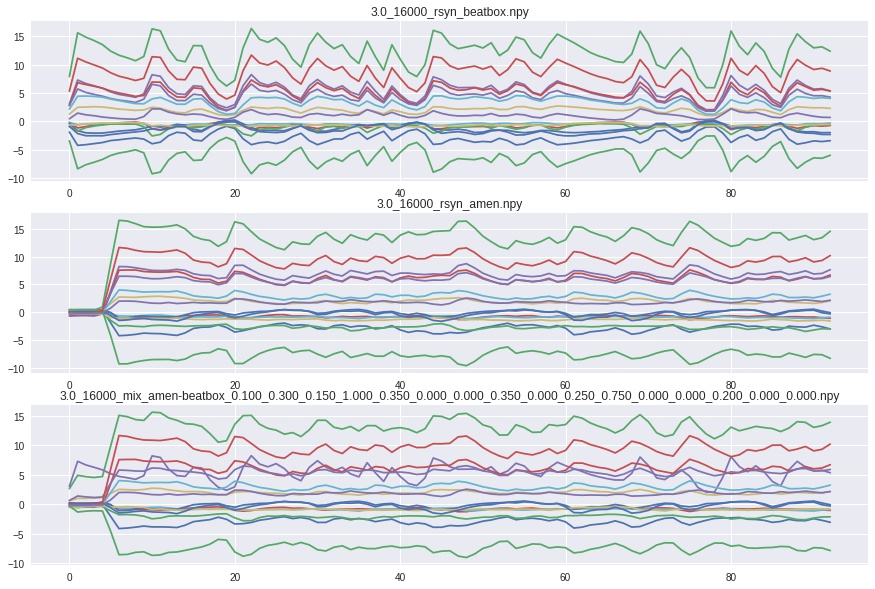

In [12]:
#@title Visualize three encodings

file1 = "3.0_16000_rsyn_beatbox.npy" #@param {type: "string"}
file2 = "3.0_16000_rsyn_amen.npy" #@param {type: "string"}
file3 = "3.0_16000_mix_amen-beatbox_0.100_0.300_0.150_1.000_0.350_0.000_0.000_0.350_0.000_0.250_0.750_0.000_0.000_0.200_0.000_0.000.npy" #@param {type: "string"}

epath = "encodings"

enc1 = np.load(os.path.join(epath,file1))
enc2 = np.load(os.path.join(epath,file2))
enc3 = np.load(os.path.join(epath,file3))

fig, axs = plt.subplots(3, 1, figsize=(15, 10))
axs[0].plot(enc1[0]);
axs[0].set_title(file1)
axs[1].plot(enc2[0]);
axs[1].set_title(file2)
axs[2].plot(enc3[0]);
axs[2].set_title(file3)

# Decode encodings

Run the Decoding Setup cell before running the Start Decoding cell. The Decoding Setup cell will output an array shape. The shape of this array should look like this:

( number of encodings,   time length of encodings,  16 )

**If the encodings have different time lengths than the array shape will show nothing in the second value of the array shape. This will result in the decoding process not working.**

In [16]:
#@title Decoding Setup

# path to the directory of encodings
Encoding_Path = "encodings" #@param {type:'string'}

# path to the directory where the audio will be saved
Save_Path = "audio" #@param {type:'string'}

SR = 16000

Model = "Instruments" #@param ["Instruments", "Voices"] {type:"string"}

encodings = [np.squeeze(np.load(os.path.join(Encoding_Path, f))) for f in os.listdir(Encoding_Path) if f.endswith('.npy')]

outnames = [os.path.join(Save_Path, f.replace('.npy', '.wav')) for f in os.listdir(Encoding_Path) if f.endswith('.npy')]
  
enc_array = np.array(encodings)

print('Encoding Array Shape: ',enc_array.shape)

Encoding Array Shape:  (4, 93, 16)


**DO NOT LET YOUR COMPUTER SLEEP DURING THIS PROCESS!**

In [17]:
#@title Start Decoding
%time fastgen.synthesize(enc_array,save_paths=outnames,checkpoint_path=ckpts[Model],samples_per_save=16000)

INFO:tensorflow:Saving: audio/3.0_16000_rsyn_beatbox.wav
INFO:tensorflow:Saving: audio/3.0_16000_gain_amen_1.062_0.881_0.858_0.861_1.073_0.983_1.065_1.048_1.039_0.908_0.805_1.031_1.079_0.983_0.813_1.041.wav
INFO:tensorflow:Saving: audio/3.0_16000_rsyn_amen.wav
INFO:tensorflow:Saving: audio/3.0_16000_mix_amen-beatbox_0.100_0.300_0.150_1.000_0.350_0.000_0.000_0.350_0.000_0.250_0.750_0.000_0.000_0.200_0.000_0.000.wav
INFO:tensorflow:Sample: 100
INFO:tensorflow:Sample: 200
INFO:tensorflow:Sample: 300
INFO:tensorflow:Sample: 400
INFO:tensorflow:Sample: 500
INFO:tensorflow:Sample: 600
INFO:tensorflow:Sample: 700
INFO:tensorflow:Sample: 800
INFO:tensorflow:Sample: 900
INFO:tensorflow:Sample: 1000
INFO:tensorflow:Sample: 1100
INFO:tensorflow:Sample: 1200
INFO:tensorflow:Sample: 1300
INFO:tensorflow:Sample: 1400
INFO:tensorflow:Sample: 1500
INFO:tensorflow:Sample: 1600
INFO:tensorflow:Sample: 1700
INFO:tensorflow:Sample: 1800
INFO:tensorflow:Sample: 1900
INFO:tensorflow:Sample: 2000
INFO:tensor

INFO:tensorflow:Sample: 7000
INFO:tensorflow:Sample: 7100
INFO:tensorflow:Sample: 7200
INFO:tensorflow:Sample: 7300
INFO:tensorflow:Sample: 7400
INFO:tensorflow:Sample: 7500
INFO:tensorflow:Sample: 7600
INFO:tensorflow:Sample: 7700
INFO:tensorflow:Sample: 7800
INFO:tensorflow:Sample: 7900
INFO:tensorflow:Sample: 8000
INFO:tensorflow:Sample: 8100
INFO:tensorflow:Sample: 8200
INFO:tensorflow:Sample: 8300
INFO:tensorflow:Sample: 8400
INFO:tensorflow:Sample: 8500
INFO:tensorflow:Sample: 8600
INFO:tensorflow:Sample: 8700
INFO:tensorflow:Sample: 8800
INFO:tensorflow:Sample: 8900
INFO:tensorflow:Sample: 9000
INFO:tensorflow:Sample: 9100
INFO:tensorflow:Sample: 9200
INFO:tensorflow:Sample: 9300
INFO:tensorflow:Sample: 9400
INFO:tensorflow:Sample: 9500
INFO:tensorflow:Sample: 9600
INFO:tensorflow:Sample: 9700
INFO:tensorflow:Sample: 9800
INFO:tensorflow:Sample: 9900
INFO:tensorflow:Sample: 10000
INFO:tensorflow:Sample: 10100
INFO:tensorflow:Sample: 10200
INFO:tensorflow:Sample: 10300
INFO:tenso

INFO:tensorflow:Sample: 15100
INFO:tensorflow:Sample: 15200
INFO:tensorflow:Sample: 15300
INFO:tensorflow:Sample: 15400
INFO:tensorflow:Sample: 15500
INFO:tensorflow:Sample: 15600
INFO:tensorflow:Sample: 15700
INFO:tensorflow:Sample: 15800
INFO:tensorflow:Sample: 15900
INFO:tensorflow:Sample: 16000
INFO:tensorflow:Saving: audio/3.0_16000_rsyn_beatbox.wav
INFO:tensorflow:Saving: audio/3.0_16000_gain_amen_1.062_0.881_0.858_0.861_1.073_0.983_1.065_1.048_1.039_0.908_0.805_1.031_1.079_0.983_0.813_1.041.wav
INFO:tensorflow:Saving: audio/3.0_16000_rsyn_amen.wav
INFO:tensorflow:Saving: audio/3.0_16000_mix_amen-beatbox_0.100_0.300_0.150_1.000_0.350_0.000_0.000_0.350_0.000_0.250_0.750_0.000_0.000_0.200_0.000_0.000.wav
INFO:tensorflow:Sample: 16100
INFO:tensorflow:Sample: 16200
INFO:tensorflow:Sample: 16300
INFO:tensorflow:Sample: 16400
INFO:tensorflow:Sample: 16500
INFO:tensorflow:Sample: 16600
INFO:tensorflow:Sample: 16700
INFO:tensorflow:Sample: 16800
INFO:tensorflow:Sample: 16900
INFO:tensorf

INFO:tensorflow:Sample: 22000
INFO:tensorflow:Sample: 22100
INFO:tensorflow:Sample: 22200
INFO:tensorflow:Sample: 22300
INFO:tensorflow:Sample: 22400
INFO:tensorflow:Sample: 22500
INFO:tensorflow:Sample: 22600
INFO:tensorflow:Sample: 22700
INFO:tensorflow:Sample: 22800
INFO:tensorflow:Sample: 22900
INFO:tensorflow:Sample: 23000
INFO:tensorflow:Sample: 23100
INFO:tensorflow:Sample: 23200
INFO:tensorflow:Sample: 23300
INFO:tensorflow:Sample: 23400
INFO:tensorflow:Sample: 23500
INFO:tensorflow:Sample: 23600
INFO:tensorflow:Sample: 23700
INFO:tensorflow:Sample: 23800
INFO:tensorflow:Sample: 23900
INFO:tensorflow:Sample: 24000
INFO:tensorflow:Sample: 24100
INFO:tensorflow:Sample: 24200
INFO:tensorflow:Sample: 24300
INFO:tensorflow:Sample: 24400
INFO:tensorflow:Sample: 24500
INFO:tensorflow:Sample: 24600
INFO:tensorflow:Sample: 24700
INFO:tensorflow:Sample: 24800
INFO:tensorflow:Sample: 24900
INFO:tensorflow:Sample: 25000
INFO:tensorflow:Sample: 25100
INFO:tensorflow:Sample: 25200
INFO:tenso

INFO:tensorflow:Sample: 30100
INFO:tensorflow:Sample: 30200
INFO:tensorflow:Sample: 30300
INFO:tensorflow:Sample: 30400
INFO:tensorflow:Sample: 30500
INFO:tensorflow:Sample: 30600
INFO:tensorflow:Sample: 30700
INFO:tensorflow:Sample: 30800
INFO:tensorflow:Sample: 30900
INFO:tensorflow:Sample: 31000
INFO:tensorflow:Sample: 31100
INFO:tensorflow:Sample: 31200
INFO:tensorflow:Sample: 31300
INFO:tensorflow:Sample: 31400
INFO:tensorflow:Sample: 31500
INFO:tensorflow:Sample: 31600
INFO:tensorflow:Sample: 31700
INFO:tensorflow:Sample: 31800
INFO:tensorflow:Sample: 31900
INFO:tensorflow:Sample: 32000
INFO:tensorflow:Saving: audio/3.0_16000_rsyn_beatbox.wav
INFO:tensorflow:Saving: audio/3.0_16000_gain_amen_1.062_0.881_0.858_0.861_1.073_0.983_1.065_1.048_1.039_0.908_0.805_1.031_1.079_0.983_0.813_1.041.wav
INFO:tensorflow:Saving: audio/3.0_16000_rsyn_amen.wav
INFO:tensorflow:Saving: audio/3.0_16000_mix_amen-beatbox_0.100_0.300_0.150_1.000_0.350_0.000_0.000_0.350_0.000_0.250_0.750_0.000_0.000_0.20

INFO:tensorflow:Sample: 37100
INFO:tensorflow:Sample: 37200
INFO:tensorflow:Sample: 37300
INFO:tensorflow:Sample: 37400
INFO:tensorflow:Sample: 37500
INFO:tensorflow:Sample: 37600
INFO:tensorflow:Sample: 37700
INFO:tensorflow:Sample: 37800
INFO:tensorflow:Sample: 37900
INFO:tensorflow:Sample: 38000
INFO:tensorflow:Sample: 38100
INFO:tensorflow:Sample: 38200
INFO:tensorflow:Sample: 38300
INFO:tensorflow:Sample: 38400
INFO:tensorflow:Sample: 38500
INFO:tensorflow:Sample: 38600
INFO:tensorflow:Sample: 38700
INFO:tensorflow:Sample: 38800
INFO:tensorflow:Sample: 38900
INFO:tensorflow:Sample: 39000
INFO:tensorflow:Sample: 39100
INFO:tensorflow:Sample: 39200
INFO:tensorflow:Sample: 39300
INFO:tensorflow:Sample: 39400
INFO:tensorflow:Sample: 39500
INFO:tensorflow:Sample: 39600
INFO:tensorflow:Sample: 39700
INFO:tensorflow:Sample: 39800
INFO:tensorflow:Sample: 39900
INFO:tensorflow:Sample: 40000
INFO:tensorflow:Sample: 40100
INFO:tensorflow:Sample: 40200
INFO:tensorflow:Sample: 40300
INFO:tenso

INFO:tensorflow:Sample: 45200
INFO:tensorflow:Sample: 45300
INFO:tensorflow:Sample: 45400
INFO:tensorflow:Sample: 45500
INFO:tensorflow:Sample: 45600
INFO:tensorflow:Sample: 45700
INFO:tensorflow:Sample: 45800
INFO:tensorflow:Sample: 45900
INFO:tensorflow:Sample: 46000
INFO:tensorflow:Sample: 46100
INFO:tensorflow:Sample: 46200
INFO:tensorflow:Sample: 46300
INFO:tensorflow:Sample: 46400
INFO:tensorflow:Sample: 46500
INFO:tensorflow:Sample: 46600
INFO:tensorflow:Sample: 46700
INFO:tensorflow:Sample: 46800
INFO:tensorflow:Sample: 46900
INFO:tensorflow:Sample: 47000
INFO:tensorflow:Sample: 47100
INFO:tensorflow:Sample: 47200
INFO:tensorflow:Sample: 47300
INFO:tensorflow:Sample: 47400
INFO:tensorflow:Sample: 47500
INFO:tensorflow:Sample: 47600
INFO:tensorflow:Saving: audio/3.0_16000_rsyn_beatbox.wav
INFO:tensorflow:Saving: audio/3.0_16000_gain_amen_1.062_0.881_0.858_0.861_1.073_0.983_1.065_1.048_1.039_0.908_0.805_1.031_1.079_0.983_0.813_1.041.wav
INFO:tensorflow:Saving: audio/3.0_16000_rsy

# Download files

This cell will download files directly to your system. This my take a while because it downloads the files one at a time.

In [19]:
#@title Select the directory you want to download

from google.colab import files

download_path = "audio" #@param {type: "string"}
output_files = os.listdir(download_path)

print(download_path+" has "+str(len(output_files))+" files.")

for i in range(len(output_files)):
  files.download(os.path.join(download_path,output_files[i]))

audio has 4 files.


This file will upload files straight to your Google Drive.

**gdrive_folder_id:** Create a folder in your Google Drive for the files to be uploaded to. Get the folder id in the same way you get a file id (see Encode Audio section for details) and paste it next to gdrive_folder_id. 

In [0]:
#@title Select the directory you want to upload to your google drive

download_path = "audio" #@param {type: "string"}
file_names = os.listdir(download_path)

gdrive_folder_id = "1hmVd8wYR2HvanzyjZIVgB0PTD8pHtOLj" #@param {type: "string"}

for file_name in file_names:
  # uploaded = drive.CreateFile({'title': '1.0_16000_rsyn_Descent(S).wav'})
  uploaded = drive.CreateFile({'parents':[{u'id': gdrive_folder_id}],
                              'title':file_name})
  uploaded.SetContentFile(os.path.join(download_path,file_name))
  uploaded.Upload()